In [1]:
import pandas as pd
import numpy as np
import arviz as az
import graphviz as gz
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns
from scipy.special import expit as logistic
from patsy import dmatrix

sns.set()
az.style.use("arviz-darkgrid")

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

In [2]:
data_path = 'data/processed_data.csv'

In [3]:
data = pd.read_csv(data_path)

/var/folders/5l/01f91zmj7mq1k2wrl_k7z2740000gn/T/ipykernel_46473/560202589.py:1: DtypeWarning: Columns (579,629,630,631,664,665,666,667,668,669,670,684,685,686,687,688,714) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [4]:
data.head()

,Unnamed: 0,CCAA,TMUNI,IDENTHOGAR,NORDEN,SEXO,EDAD,INFOR_DISC,INFOR_HOG,INFOR_RELAC,...,B_15_3,B_15_4,B_15_5,B_15_6,B_15_7,B_15_8,B_15_9,B_15_10,B_16,FACTOR
0,1,16,4,7,1,1,56,1,,,...,,,,,,,,,,222.916
1,2,16,4,10,2,1,67,1,,,...,,,,,,,,,,296.805
2,3,16,5,21,1,2,52,1,,,...,,,,,,,,,,300.734
3,4,16,5,24,3,1,37,6,1,3,...,,,,,,,,,,326.648
4,5,16,5,30,4,1,56,1,,,...,,,,,,,,,,324.750


In [5]:
relevant_columns = ['SEXO', 'EDAD', 'H_14']

In [6]:
data = data[relevant_columns]

In [7]:
data = data.rename(columns={'SEXO': 'sex', 'EDAD': 'age', 'H_14': 'discrimination'})

In [8]:
data['sex'] -= 1

In [9]:
data.head()

,sex,age,discrimination
0,0,56,1
1,0,67,1
2,1,52,1
3,0,37,1
4,0,56,2


In [10]:
data.discrimination.unique()

array([1, 2, 9, 3, 4])

In [11]:
data.sex.unique()

array([0, 1])

In [12]:
data.age.sort_values().unique()

array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 104, 106])

In [13]:
data = data.query('discrimination != 9')

In [14]:
data['discrimination_n'] = data.discrimination / data.discrimination.max()

In [15]:
#data = data.sample(5000)

In [16]:
data.groupby('sex').discrimination.mean()

sex
0    1.136951
1    1.104550
Name: discrimination, dtype: float64

In [17]:
data.sort_values(by='age', inplace=True)

In [18]:
data.head()

,sex,age,discrimination,discrimination_n
8262,1,6,1,0.25
9627,1,6,1,0.25
9236,0,6,1,0.25
5571,0,6,1,0.25
44,0,6,1,0.25


In [19]:
num_knots = 4
knot_list = np.linspace(0, 110, num_knots+2)[1:-1]

In [20]:
data = data.astype(float)

In [21]:
data['discrimination_n'] = data.discrimination / data.discrimination.max()

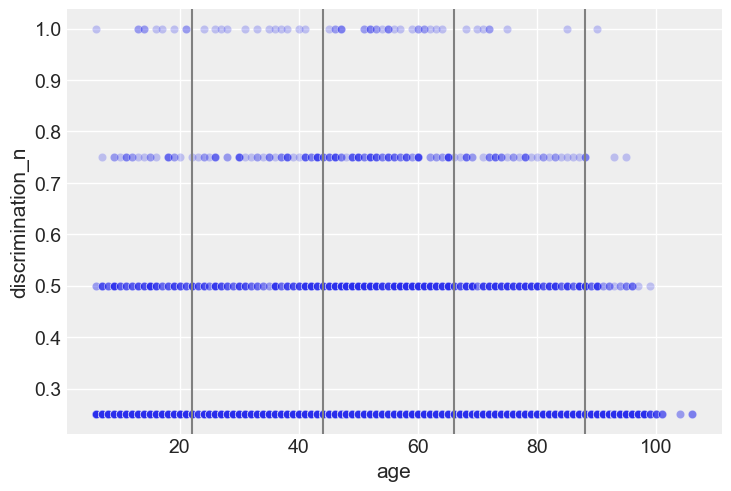

In [22]:
sns.scatterplot(data=data, x='age', y='discrimination_n', alpha=0.25)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey");
plt.show()

In [23]:
B = dmatrix(
    'bs(age, knots=knots, degree=3, include_intercept=True) - 1',
    {'age': data.age.sort_values(), 'knots': knot_list},
)

In [24]:
COORDS = {"splines": np.arange(B.shape[1])}
with pm.Model(coords=COORDS) as spline_model:
    w = pm.Normal("w", mu=0, sigma=1, size=B.shape[1], dims="splines")
    mu = pm.Deterministic("mu", pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=data.discrimination_n)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=1000, tune=1000, random_seed=RANDOM_SEED, chains=4))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [D, sigma, w]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [D]


In [25]:
az.summary(idata, var_names=["w", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.315,0.013,0.291,0.342,0.000,0.000,3071.0,2964.0,1.0
w[1],0.332,0.013,0.308,0.355,0.000,0.000,2357.0,2665.0,1.0
w[2],0.367,0.012,0.345,0.388,0.000,0.000,2019.0,2297.0,1.0
w[3],0.313,0.006,0.302,0.325,0.000,0.000,1722.0,2014.0,1.0
w[4],0.266,0.005,0.257,0.276,0.000,0.000,1614.0,1984.0,1.0
w[5],0.259,0.006,0.247,0.270,0.000,0.000,1659.0,2000.0,1.0
w[6],0.258,0.010,0.240,0.277,0.000,0.000,2030.0,2198.0,1.0
w[7],0.260,0.042,0.183,0.340,0.001,0.001,3337.0,2927.0,1.0
sigma,0.100,0.001,0.099,0.101,0.000,0.000,4732.0,2900.0,1.0


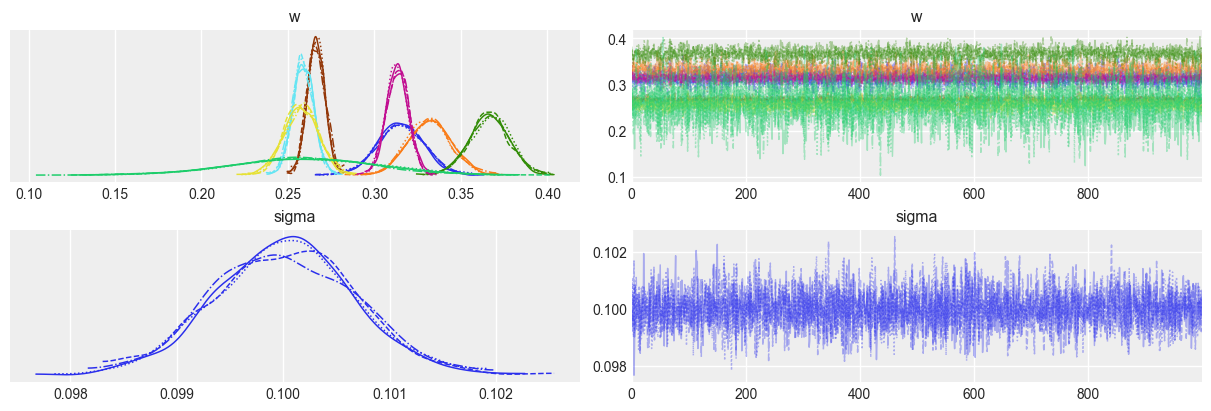

In [26]:
az.plot_trace(idata, var_names=["w", "sigma"]);

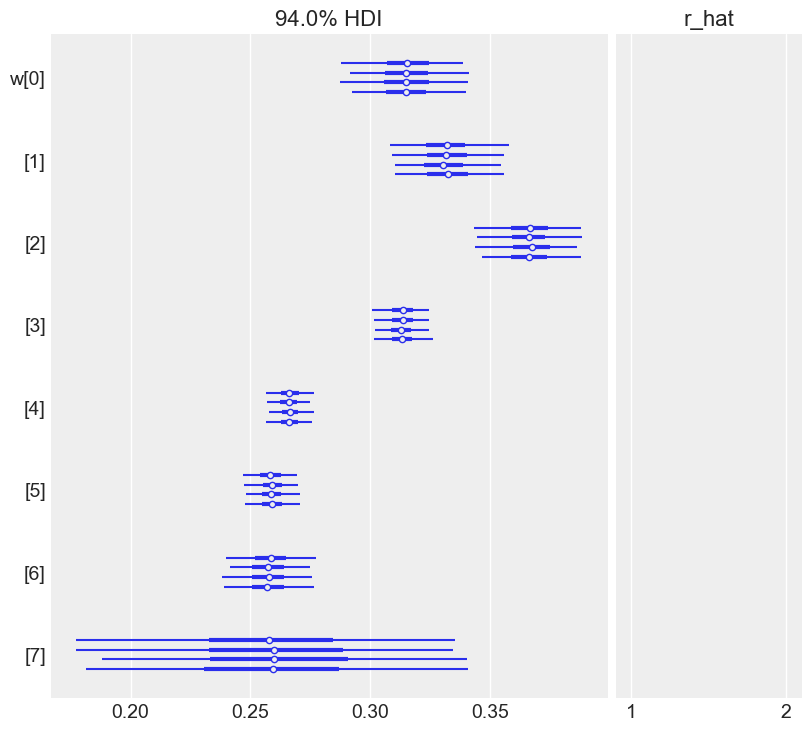

In [27]:
az.plot_forest(idata, var_names=["w"], combined=False, r_hat=True);

In [28]:
post_pred = az.summary(idata, var_names=["mu"]).reset_index(drop=True)
data_post = data.copy().reset_index(drop=True)
data_post["pred_mean"] = post_pred["mean"]
data_post["pred_hdi_lower"] = post_pred["hdi_3%"]
data_post["pred_hdi_upper"] = post_pred["hdi_97%"]

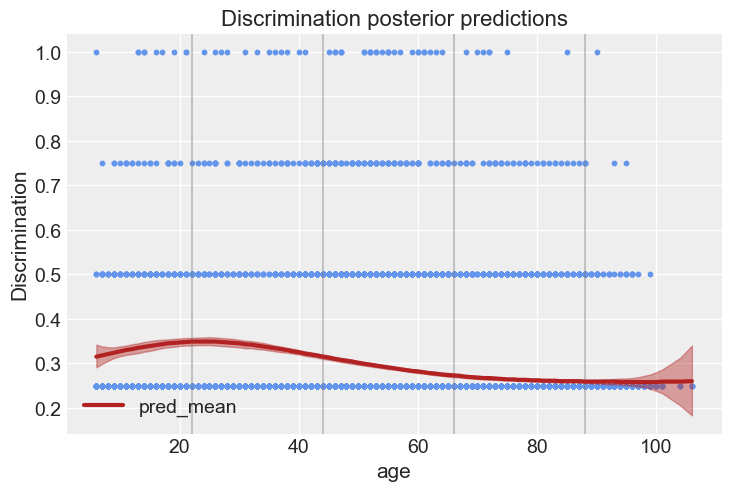

In [29]:
data.plot.scatter(
    "age",
    "discrimination_n",
    color="cornflowerblue",
    s=10,
    title="Discrimination posterior predictions",
    ylabel="Discrimination",
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4)

data_post.plot("age", "pred_mean", ax=plt.gca(), lw=3, color="firebrick")
plt.fill_between(
    data_post.age,
    data_post.pred_hdi_lower,
    data_post.pred_hdi_upper,
    color="firebrick",
    alpha=0.4,
);

# Sex & Age:

In [30]:
COORDS = {"splines": np.arange(B.shape[1]), "sex": [0, 1]}
with pm.Model(coords=COORDS) as spline_model:
    # Separate spline coefficients for each sex
    w_0 = pm.Normal("w_0", mu=0, sigma=1, size=B.shape[1], dims="splines")
    w_1 = pm.Normal("w_1", mu=0, sigma=1, size=B.shape[1], dims="splines")

    # Conditional structure for applying spline coefficients
    mu_0 = pm.Deterministic("mu_0", pm.math.dot(np.asarray(B, order="F"), w_0.T))
    mu_1 = pm.Deterministic("mu_1", pm.math.dot(np.asarray(B, order="F"), w_1.T))
    mu = pm.math.switch(pm.math.eq(data.sex, 0), mu_0, mu_1)

    # Rest of the model remains the same
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=data.discrimination_n)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=1000, tune=1000, random_seed=RANDOM_SEED, chains=4))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

    # Posterior analysis
    # Here you can compute the contrasts between w_0 and w_1 posteriors

Sampling: [D, sigma, w_0, w_1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [D]


In [31]:
az.summary(idata, var_names=["w_0", "w_1","sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w_0[0],0.318,0.017,0.289,0.350,0.000,0.000,4253.0,3194.0,1.0
w_0[1],0.352,0.016,0.322,0.382,0.000,0.000,3653.0,3072.0,1.0
w_0[2],0.338,0.016,0.309,0.367,0.000,0.000,3248.0,2940.0,1.0
w_0[3],0.331,0.009,0.313,0.348,0.000,0.000,2810.0,2713.0,1.0
w_0[4],0.255,0.008,0.240,0.271,0.000,0.000,2612.0,2809.0,1.0
w_0[5],0.270,0.011,0.248,0.291,0.000,0.000,2717.0,2799.0,1.0
w_0[6],0.244,0.022,0.204,0.287,0.000,0.000,3007.0,2896.0,1.0
w_0[7],0.381,0.191,0.030,0.753,0.003,0.002,3906.0,3138.0,1.0
w_1[0],0.296,0.023,0.252,0.341,0.000,0.000,5133.0,3602.0,1.0
w_1[1],0.307,0.019,0.269,0.342,0.000,0.000,3808.0,2992.0,1.0


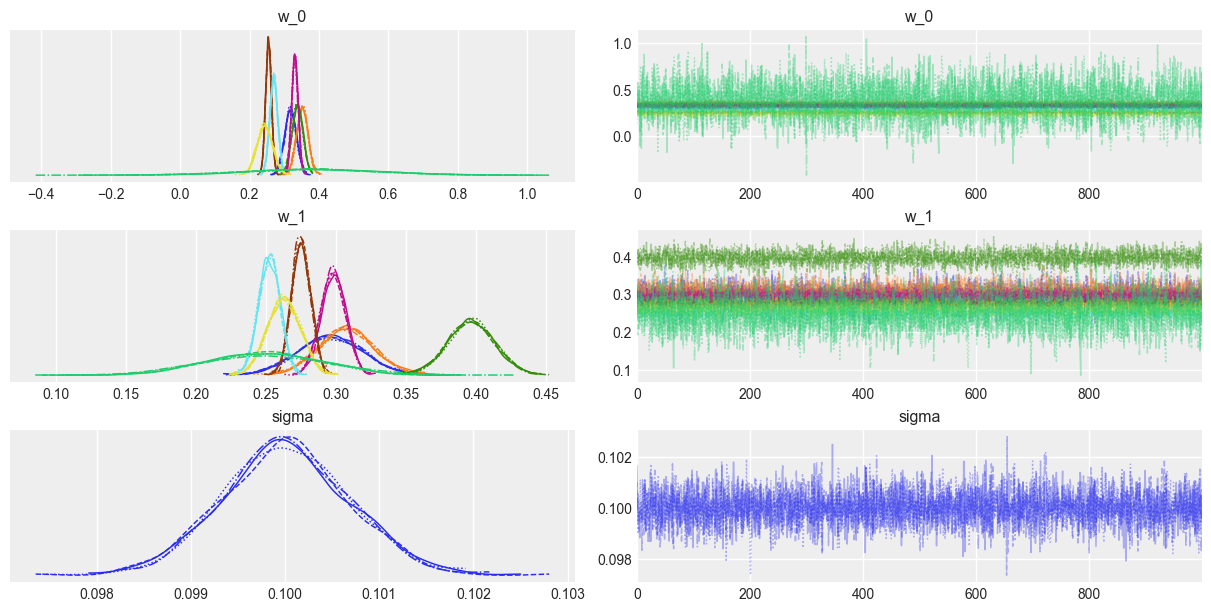

In [32]:
az.plot_trace(idata, var_names=["w_0", "w_1", "sigma"]);

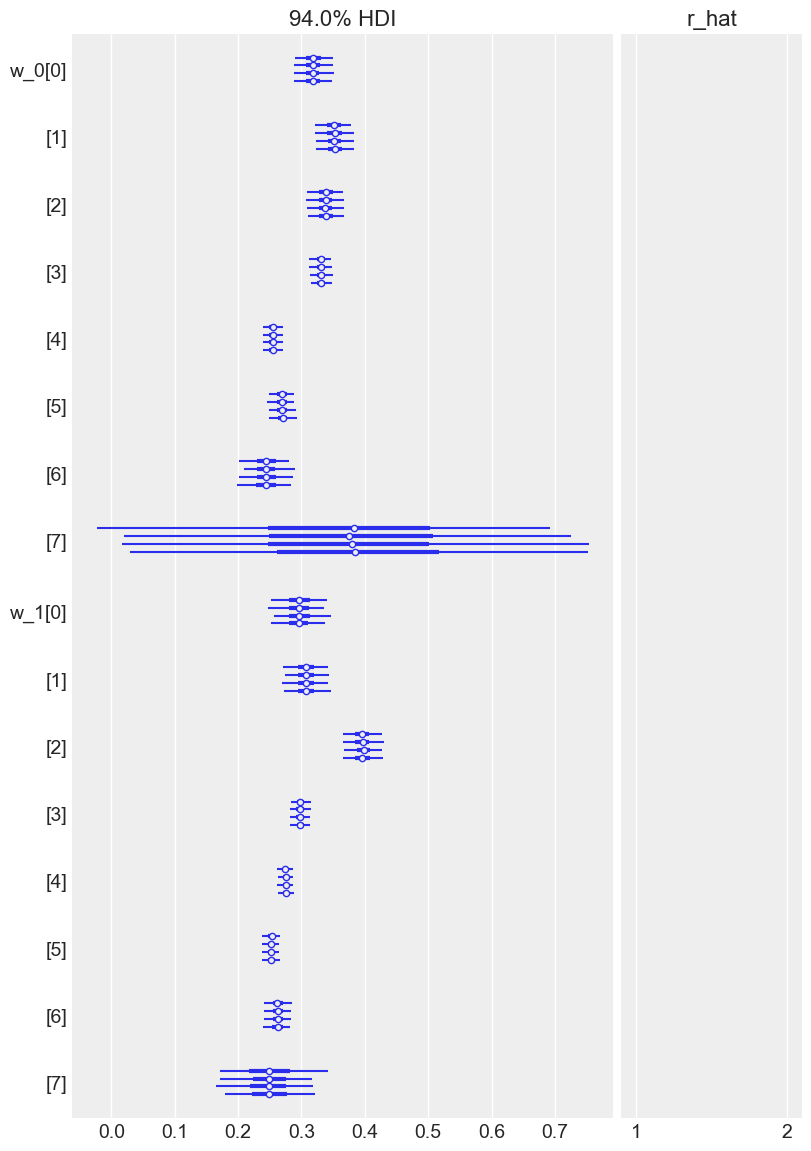

In [33]:
az.plot_forest(idata, var_names=["w_0", "w_1"], combined=False, r_hat=True);

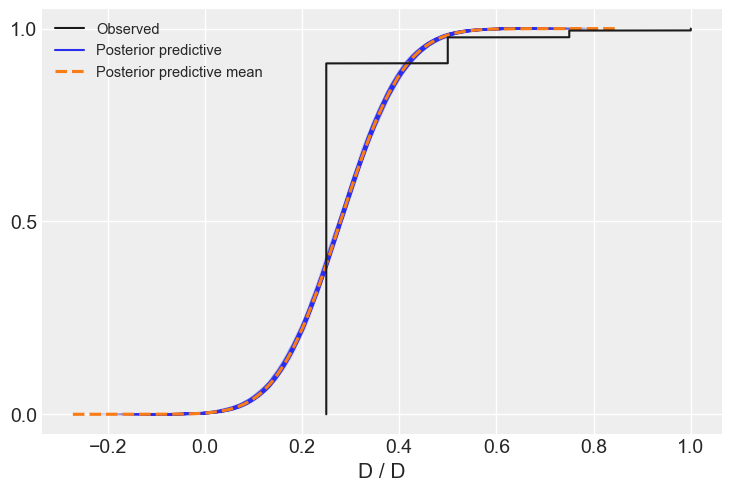

In [34]:
az.plot_ppc(idata, num_pp_samples=100, kind='cumulative')
plt.show()

In [39]:
n_samples = 4000

/var/folders/5l/01f91zmj7mq1k2wrl_k7z2740000gn/T/ipykernel_46473/712096184.py:32: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_97 = az.hdi(contrasts, hdi_prob=0.97)
/var/folders/5l/01f91zmj7mq1k2wrl_k7z2740000gn/T/ipykernel_46473/712096184.py:33: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_50 = az.hdi(contrasts, hdi_prob=0.50)


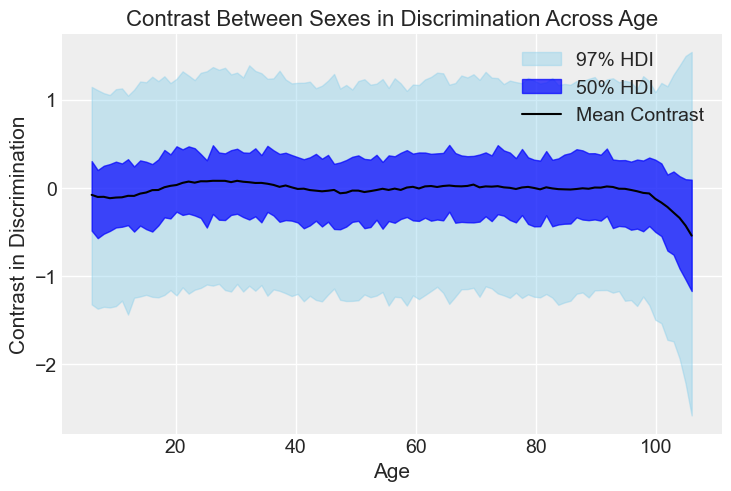

In [45]:
# Create age grid and basis matrix for the age grid
age_grid = np.linspace(data.age.min(), data.age.max(), 100)
B_grid = dmatrix(
    'bs(age, knots=knots, degree=3, include_intercept=True) - 1',
    {'age': age_grid, 'knots': knot_list},
)

n_samples = 4000


with spline_model:
    
    w_0_samples = idata.posterior['w_0'].values
    w_1_samples = idata.posterior['w_1'].values
    sigma_samples = idata.posterior['sigma'].values

    # Predictions for each sex across the age grid
    mu_0 = np.dot(B_grid, w_0_samples.reshape(-1, B_grid.shape[1]).T)
    mu_1 = np.dot(B_grid, w_1_samples.reshape(-1, B_grid.shape[1]).T)

    # Ensure the shapes are compatible
    mu_0 = mu_0.T  # Shape: (n_samples, len(age_grid))
    mu_1 = mu_1.T  # Shape: (n_samples, len(age_grid))
    
    # Draw samples from the Gaussian likelihood
    ppd_sex0 = np.random.normal(mu_0, sigma_samples.reshape(n_samples, 1))
    ppd_sex1 = np.random.normal(mu_1, sigma_samples.reshape(n_samples, 1))

# Calculate contrasts
contrasts = 4*(ppd_sex1 - ppd_sex0)  

hdi_97 = az.hdi(contrasts, hdi_prob=0.97)
hdi_50 = az.hdi(contrasts, hdi_prob=0.50)

# Calculate mean contrast
mean_contrast = contrasts.mean(axis=0)

# Plotting
plt.fill_between(age_grid, hdi_97[:, 0], hdi_97[:, 1], color='skyblue', alpha=0.4, label='97% HDI')
plt.fill_between(age_grid, hdi_50[:, 0], hdi_50[:, 1], color='blue', alpha=0.7, label='50% HDI')
plt.plot(age_grid, mean_contrast, label='Mean Contrast', color='black')
plt.xlabel('Age')
plt.ylabel('Contrast in Discrimination')
plt.title('Contrast Between Sexes in Discrimination Across Age')
plt.legend()
plt.show()

In [46]:
4*contrasts.mean()

-0.09883171507248507

In [49]:
np.quantile(contrasts, q=0.025), np.quantile(contrasts, q=0.975)

(-1.1940971156652551, 1.1104064689015645)

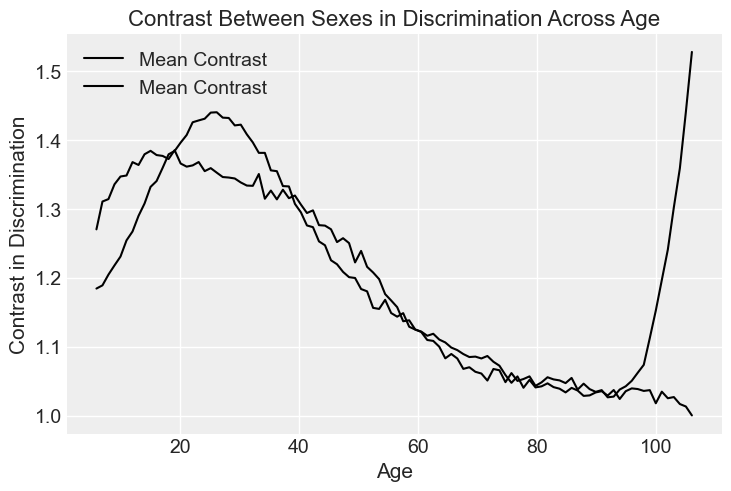

In [44]:
plt.plot(age_grid, 4*ppd_sex1.mean(axis=0), label='Mean Contrast', color='black')
plt.plot(age_grid, 4*ppd_sex0.mean(axis=0), label='Mean Contrast', color='black')
plt.xlabel('Age')
plt.ylabel('Contrast in Discrimination')
plt.title('Contrast Between Sexes in Discrimination Across Age')
plt.legend()
plt.show()